In [1]:
import torch
import torch.nn as nn
import numpy as np
import random                                                                  
import matplotlib.pyplot as plt
torch.backends.cudnn.deterministic=True
from torch.nn import functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import math
from torch.autograd import grad
from Libraries import robotarm as ra
from Libraries import ICNN_net as net
from Libraries import ICNN_plot as pl
from Libraries import ICNN_optim_custom_penalty as opt
dtype = torch.float
device_c = torch.device("cpu")
device = torch.device("cuda:0")

In [2]:
#robot initialize
l1 = 3 
l2 = 2
m1 = 3
m2 = 4
robot = ra.robotarm(l1,l2,m1,m2,device)
xinit = torch.tensor([[-2],[2]],dtype=dtype)
#xinit = torch.tensor([[0],[3]],dtype=dtype)
xfinal = torch.tensor([[3],[3]],dtype=dtype)
#xinit = torch.tensor([[-3],[0]],dtype=dtype)
#xfinal = torch.tensor([[3],[2.5]],dtype=dtype)
T = 3
delta = 0.6
num_timesteps = 100
xpoints = np.array([  2.5,1.5,1 ,1.5,2.5])
ypoints = np.array([  0.5,1  ,1.5,2  ,2.5])
#rmin,rmax,qmin,qmax,dt,qinit,qfinal,Xstable,xtraj,x_dot,qtraj,q_dot = robot.Initialize(xinit,xfinal,T,delta,num_timesteps)
rmin,rmax,qmin,qmax,dt,qinit,qfinal,Xstable,xtraj,qtraj,q_dot = robot.Initialize_spline(xpoints,ypoints, T, delta, num_timesteps)

#ICNN initialize
fhat_size = 500
V_size = 200
V_hidden_sizes = [V_size, V_size,V_size,V_size]
fhat_hidden_sizes = [fhat_size,fhat_size,fhat_size,fhat_size,fhat_size,fhat_size,fhat_size,fhat_size,fhat_size]
tol = 0.01
alpha = 0.01
#getting grid data (for the regularizer)
nq1 = 100 # grid number
nq2 = 100 
nq1_b = 10 # grid number
nq2_b = 10
penalty = 5000
penalty_boundary = 100000
optim_ = opt.ICNN_optim(V_hidden_sizes, fhat_hidden_sizes,tol,alpha,Xstable,device) #qmin, qmax는 위에서 구함
q_in_reg,q1,q2 = optim_.get_grid(nq1,nq2,qmin,qmax)
q_in_boundary,q_dot_boundary = optim_.get_boundary(nq1_b,nq2_b,qmin,qmax)
nq1_p = 100
nq2_p = 100
nx1 = 100
nx2 = 100
xmin = [-robot.l1-robot.l2, -robot.l2]
xmax = [robot.l1+robot.l2,robot.l1+robot.l2]

# Ploting trajectory

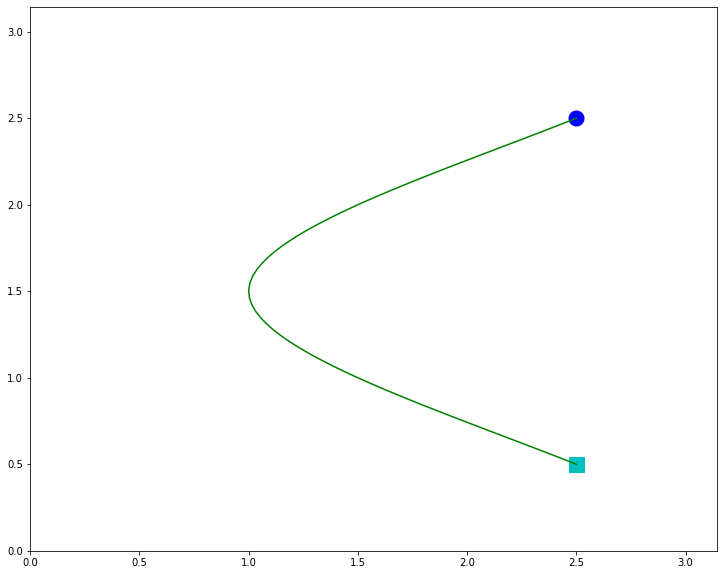

In [3]:
plt_ = pl.ICNN_plot(optim_.model,qmin,qmax,nq1_p,nq2_p,xmin,xmax,nx1,nx2,Xstable,qtraj,xtraj,l1,l2,device)
plt_.plot_q_traj('qtraj.png')

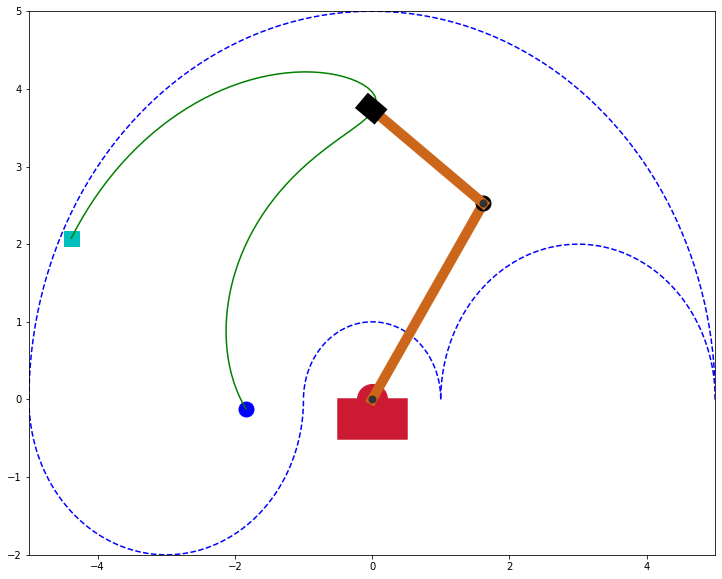

In [4]:
theta1 = xpoints[2]
theta2 = ypoints[2]
plt_.plot_robot_taskspace('robotplot.png', robot,theta1,theta2, traj=True)

# No Regularization

In [5]:
# initialize
optim_ = opt.ICNN_optim(V_hidden_sizes, fhat_hidden_sizes,tol,alpha,Xstable,device)
q_in_reg,q1,q2 = optim_.get_grid(nq1,nq2,qmin,qmax)

In [13]:
optim_.optim_no_reg(qtraj,q_dot,dt,q_in_boundary,q_dot_boundary, learning_rate = 1e-3 ,epoch=10000)

 epoch = 57, loss = 0.7964803, loss_b = 0.22787058, loss_t = 0.7445553                    . .                                                  

KeyboardInterrupt: 

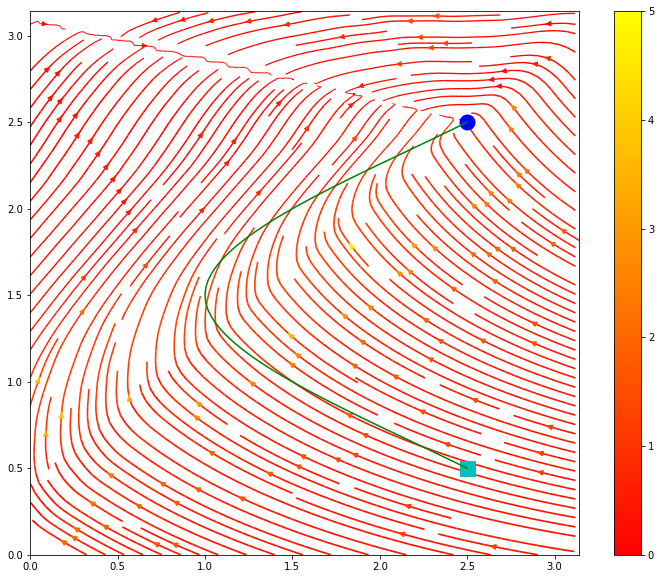

In [14]:
plt_ = pl.ICNN_plot(optim_.model,qmin,qmax,nq1_p,nq2_p,xmin,xmax,nx1,nx2,Xstable,qtraj,xtraj,l1,l2,device)
plt_.plot_f('fplot_noreg_0306_1.png', 2, .5, 1, quiver = False, streamplot = True,cmax=5)

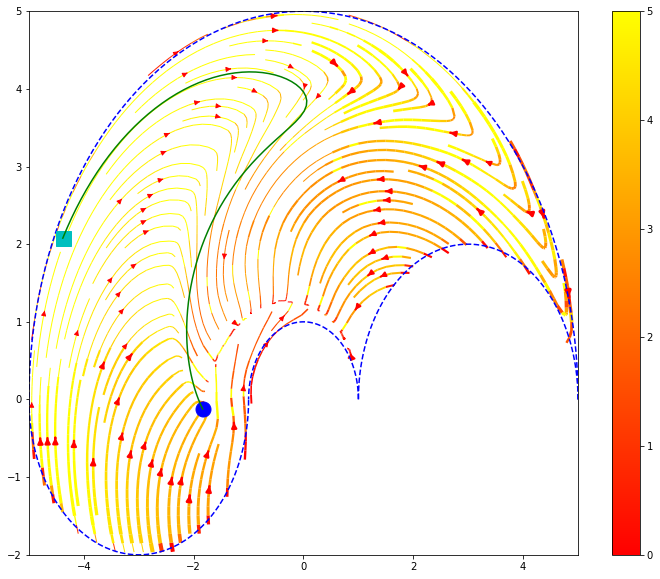

In [15]:
plt_.plot_f_taskspace('task_plot_0306_1.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=5)

## weight norm decay

In [ ]:
# initialization
optim_ = opt.ICNN_optim(V_hidden_sizes, fhat_hidden_sizes,tol,alpha,Xstable,device)
q_in_reg,q1,q2 = optim_.get_grid(nq1,nq2,qmin,qmax)

In [ ]:
#no regularization
optim_.optim_no_reg(qtraj,q_dot,dt,q_in_boundary,q_dot_boundary, learning_rate = 1e-3 ,epoch=10000)

In [11]:
#####################################################################
#weight regularization
optim_.optim_weight_reg(qtraj,q_dot,dt,q_in_boundary,q_dot_boundary, learning_rate = 1e-3 ,epoch=10000,weight_decay = 1e-4)

 epoch = 4531, loss = 0.002905826, loss_b = 0.0, loss_t = 0.002905826                    . .        .. ..                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

KeyboardInterrupt: 

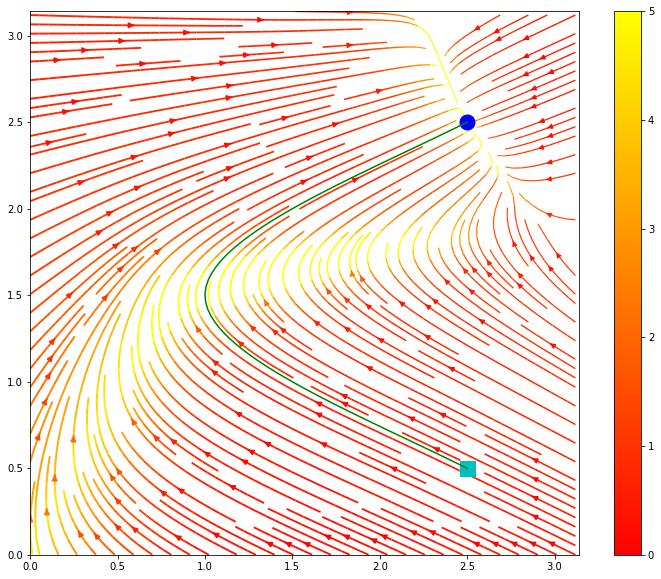

In [12]:
plt_ = pl.ICNN_plot(optim_.model,qmin,qmax,nq1_p,nq2_p,xmin,xmax,nx1,nx2,Xstable,qtraj,xtraj,l1,l2,device)
plt_.plot_f('fplot_noreg_0306_1.png', 2, .5, 1, quiver = False, streamplot = True,cmax=5)

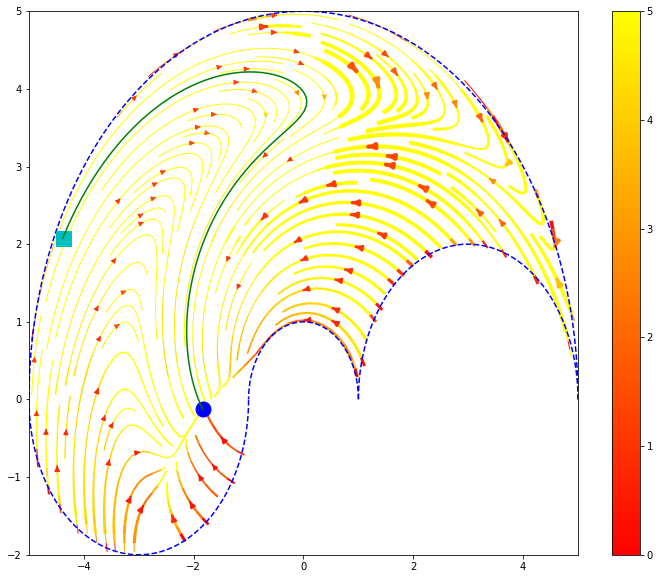

In [13]:
plt_.plot_f_taskspace('task_plot_0306_1.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=5)

# Euclidean Regularization

In [20]:
# initialization
optim_ = opt.ICNN_optim(V_hidden_sizes, fhat_hidden_sizes,tol,alpha,Xstable,device)
q_in_reg,q1,q2 = optim_.get_grid(nq1,nq2,qmin,qmax)

In [21]:
#no regularization
optim_.optim_no_reg(qtraj,q_dot,dt,q_in_boundary,q_dot_boundary, learning_rate = 1e-3 ,epoch=10000)

 epoch = 1745, loss = 0.0031296122, loss_b = 0.0, loss_t = 0.0031296122                    .    .                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

KeyboardInterrupt: 

In [22]:
#####################################################################
#weight regularization
optim_.optim_weight_reg(qtraj,q_dot,dt,q_in_boundary,q_dot_boundary, learning_rate = 1e-4 ,epoch=10000,weight_decay = 1e-4)

 epoch = 1262, loss = 0.008258733, loss_b = 0.0, loss_t = 0.008258733                    .        ....                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

KeyboardInterrupt: 

In [23]:
#optimization for Euclidean regularizer
#mode 0: exp barrier, 1: relu squared
mode = 2
optim_.optim_Euc_reg(q_in_reg,qtraj ,q_dot,dt,q_in_boundary,q_dot_boundary,penalty,penalty_boundary, learning_rate = 3e-5,epoch=100, batch_size = 40,penalty_mode = mode)

 epoch = 49 i = 250, loss = 5989.061, total_loss = 5983.7617, loss_b = 0.0, loss_t = 0.008174438, loss_reg = 19.399427, loss_reg_total =  14.096497           .           . .                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

KeyboardInterrupt: 

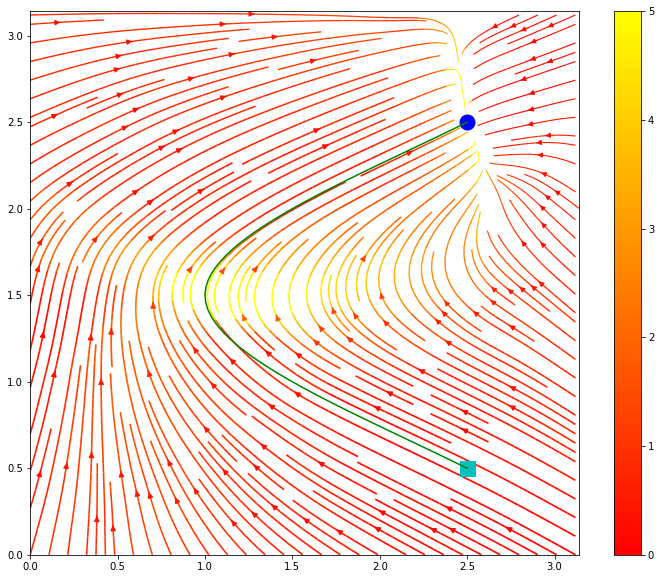

In [24]:
plt_ = pl.ICNN_plot(optim_.model,qmin,qmax,nq1_p,nq2_p,xmin,xmax,nx1,nx2,Xstable,qtraj,xtraj,l1,l2,device)
plt_.plot_f('fplot_noreg_0306_1.png', 2, .5, 1, quiver = False, streamplot = True,cmax=5)

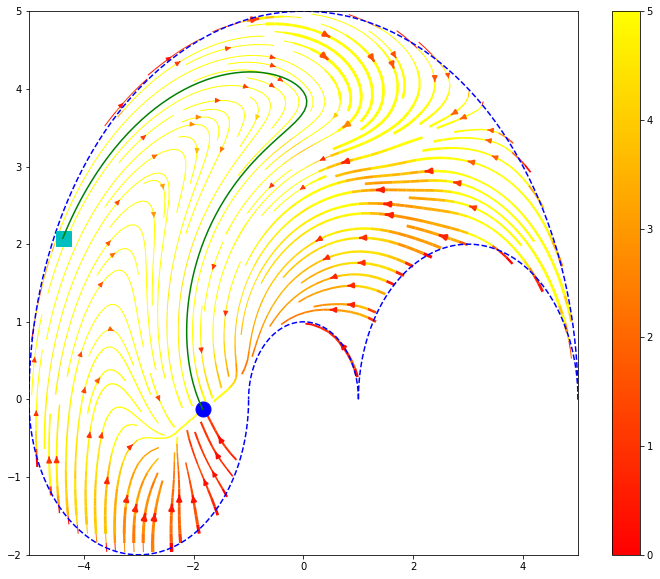

In [25]:
plt_.plot_f_taskspace('task_plot_0306_1.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=5)

# Kinematic Regularization

In [3]:
# initialization
optim_ = opt.ICNN_optim(V_hidden_sizes, fhat_hidden_sizes,tol,alpha,Xstable,device)
q_in_reg,q1,q2 = optim_.get_grid(nq1,nq2,qmin,qmax)

In [4]:
#no regularization
optim_.optim_no_reg(qtraj,q_dot,dt,q_in_boundary,q_dot_boundary, learning_rate = 1e-3 ,epoch=10000)

 epoch = 251, loss = 0.012648192, loss_b = 0.0, loss_t = 0.012648192                    . .   ..                                                                                                                                                                                                                                                    

KeyboardInterrupt: 

In [5]:
#####################################################################
#weight regularization
optim_.optim_weight_reg(qtraj,q_dot,dt,q_in_boundary,q_dot_boundary, learning_rate = 1e-4 ,epoch=1000,weight_decay = 1e-4)

 epoch = 1000, loss = 0.0010077235, loss_b = 0.00017614846, loss_t = 0.0010076924                    ..                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [18]:
#optimization for Euclidean regularizer
#mode 0: exp barrier, 1: relu squared
optim_.optim_Kinematic_reg(robot, q_in_reg,qtraj ,q_dot,dt,q_in_boundary,q_dot_boundary,penalty,penalty_boundary, Xstable, learning_rate = 3e-5,epoch=150, batch_size = 40,penalty_mode = 2)

 epoch = 6 i = 150, loss = 11566.053, total_loss = 11581.077, loss_b = 6.451584e-05, loss_t = 7.771746e-05, loss_reg = 33.622517, loss_reg_total =  43.979916           .....                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

KeyboardInterrupt: 

In [ ]:
plt_ = pl.ICNN_plot(optim_.model,qmin,qmax,nq1_p,nq2_p,xmin,xmax,nx1,nx2,Xstable,qtraj,xtraj,l1,l2,device)
plt_.plot_f('fplot_noreg_0306_1.png', 2, .5, 1, quiver = False, streamplot = True,cmax=5)

In [ ]:
plt_.plot_f_taskspace('task_plot_0306_1.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=5)

# Kinetic Regularization

In [12]:
# initialization
optim_ = opt.ICNN_optim(V_hidden_sizes, fhat_hidden_sizes,tol,alpha,Xstable,device)
q_in_reg,q1,q2 = optim_.get_grid(nq1,nq2,qmin,qmax)

In [13]:
#no regularization
optim_.optim_no_reg(qtraj,q_dot,dt,q_in_boundary,q_dot_boundary, learning_rate = 1e-3 ,epoch=10000)

 epoch = 601, loss = 0.010977829, loss_b = 0.0, loss_t = 0.010977829                    .         . .                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

KeyboardInterrupt: 

In [14]:
#####################################################################
#weight regularization
optim_.optim_weight_reg(qtraj,q_dot,dt,q_in_boundary,q_dot_boundary, learning_rate = 1e-3 ,epoch=10000,weight_decay = 1e-4)

 epoch = 762, loss = 0.001972202, loss_b = 0.0, loss_t = 0.001972202                    . .         ..                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

KeyboardInterrupt: 

In [15]:
#optimization for Euclidean regularizer
#mode 0: exp barrier, 1: relu squared
optim_.optim_Kinetic_reg(robot, q_in_reg,qtraj ,q_dot,dt,q_in_boundary,q_dot_boundary,penalty,penalty_boundary, Xstable, learning_rate = 1e-3,epoch=100, batch_size = 40,penalty_mode = 0)

 epoch = 2 i = 235, loss = 10073.9, total_loss = 10169.448, loss_b = 0.0, loss_t = 0.010491258, loss_reg = 64.07019, loss_reg_total =  160.68343           .  ..        ..                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

KeyboardInterrupt: 

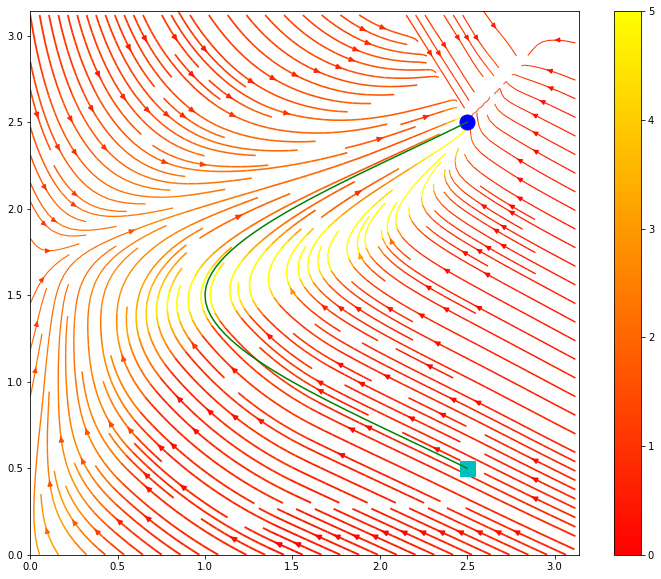

In [16]:
plt_ = pl.ICNN_plot(optim_.model,qmin,qmax,nq1_p,nq2_p,xmin,xmax,nx1,nx2,Xstable,qtraj,xtraj,l1,l2,device)
plt_.plot_f('fplot_noreg_0306_1.png', 2, .5, 1, quiver = False, streamplot = True,cmax=5)

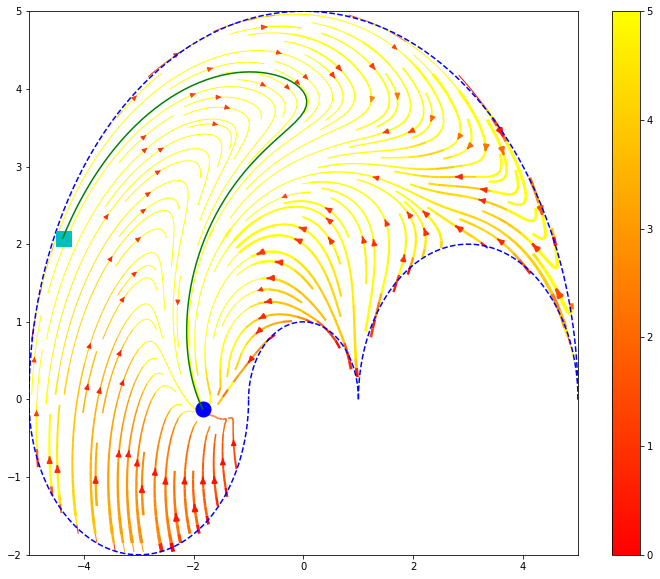

In [17]:
plt_.plot_f_taskspace('task_plot_0306_1.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=5)

In [51]:
nq1_p = 100
nq2_p = 100
nx1 = 100
nx2 = 100
xmin = [-robot.l1-robot.l2, -robot.l2]
xmax = [robot.l1+robot.l2,robot.l1+robot.l2]
plt_ = pl.ICNN_plot(optim_.model,qmin,qmax,nq1_p,nq2_p,xmin,xmax,nx1,nx2,Xstable,qtraj,xtraj,l1,l2,device)

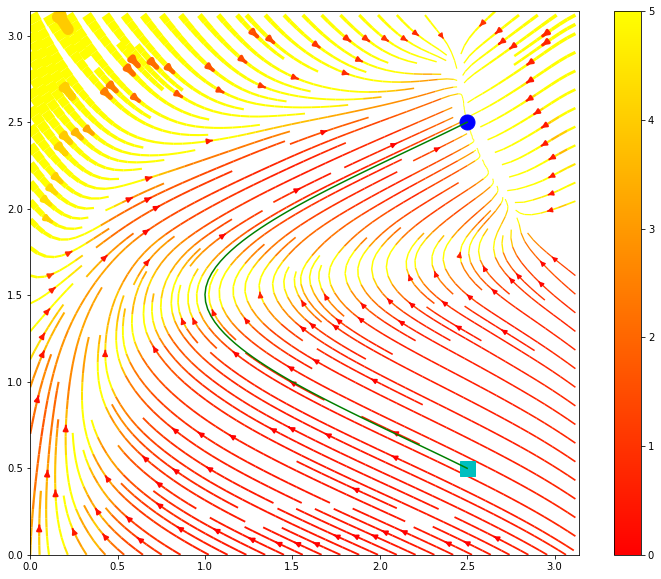

In [54]:
plt_.plot_f('fplot_noreg_0306_1.png', 2, .5, 1, quiver = False, streamplot = True,cmax=5)

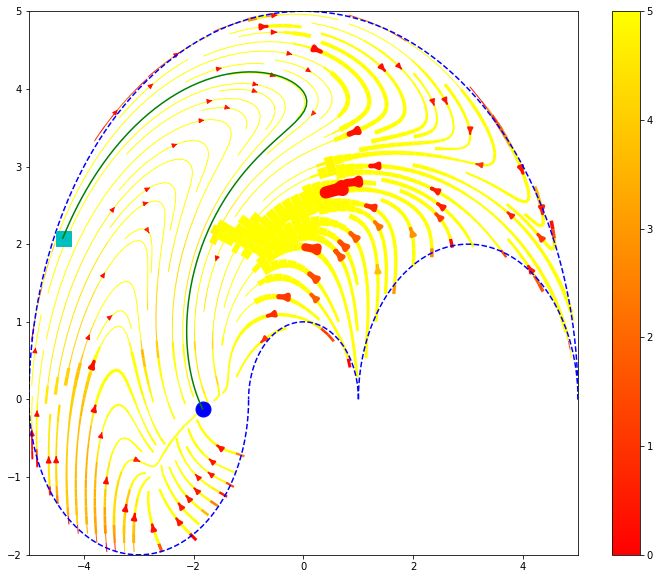

In [55]:
plt_.plot_f_taskspace('task_plot_0306_1.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=5)

In [ ]:
# initialization
optim_ = opt.ICNN_optim(V_hidden_sizes, fhat_hidden_sizes,tol,alpha,Xstable,device)

In [11]:
plt_.plot_V('t.png',3)

AttributeError: 'ICNN_net' object has no attribute 'fh_forward'